In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

c:\Users\ma053309\Desktop\kuvanluokittelu\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
path = "C:\\Users\\ma053309\\Desktop\\kuvanluokittelu\\chest_xray"

In [3]:
train_path = os.path.join(path, 'chest_xray', 'train')
test_path = os.path.join(path, 'chest_xray', 'test')
val_path = os.path.join(path, 'chest_xray', 'val')

In [4]:
def img_preprocessing (directory, shufle):
  dataset = image_dataset_from_directory(
      directory,
      label_mode = 'binary',
      image_size = (224, 224),
      batch_size = 32,
      color_mode = 'grayscale',
      shuffle = shufle
  )
  return dataset

In [5]:
train_dataset = img_preprocessing(train_path, True)
test_dataset = img_preprocessing(test_path, False)
val_dataset = img_preprocessing(val_path, False)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


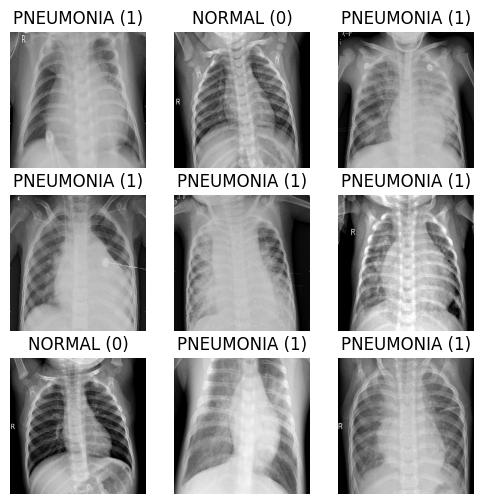

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Squeeze the (224, 224, 1) to (224, 224) for plotting
        plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray')

        # Determine the label name
        label = int(labels[i])
        class_name = train_dataset.class_names[label]

        plt.title(f"{class_name} ({label})")
        plt.axis("off")
    plt.show()

In [9]:
data_augmentation = Sequential([
    layers.RandomRotation(factor=0.08), #30deg rotation
    layers.RandomZoom(height_factor=0.1, width_factor=0.1), # 10% zoom
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), #10% left/right translation
    layers.RandomContrast(factor=0.1) # range [1.0 - 0.1, 1.0 + 0.1]
])

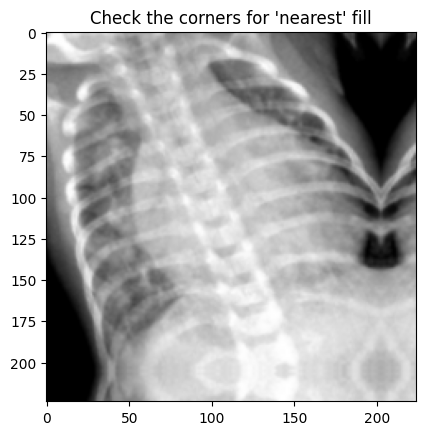

<tf.Tensor: shape=(32, 224, 224, 1), dtype=float32, numpy=
array([[[[ 58.045204 ],
         [ 59.119938 ],
         [ 60.285954 ],
         ...,
         [ 38.266155 ],
         [ 34.584526 ],
         [ 33.49666  ]],

        [[ 57.407146 ],
         [ 58.63431  ],
         [ 60.014133 ],
         ...,
         [ 38.346752 ],
         [ 34.313717 ],
         [ 32.293186 ]],

        [[ 56.52151  ],
         [ 57.221912 ],
         [ 58.515846 ],
         ...,
         [ 38.890656 ],
         [ 35.59811  ],
         [ 34.778267 ]],

        ...,

        [[ 52.1129   ],
         [ 45.921146 ],
         [ 45.305977 ],
         ...,
         [ 44.63958  ],
         [ 44.564217 ],
         [ 35.044914 ]],

        [[ 48.85761  ],
         [ 45.44417  ],
         [ 45.84199  ],
         ...,
         [ 45.038994 ],
         [ 44.41787  ],
         [ 33.928127 ]],

        [[ 46.72723  ],
         [ 45.51632  ],
         [ 45.77459  ],
         ...,
         [ 44.457405 ],
         [ 43.233

In [10]:
for images, _ in train_dataset.take(1):
    augmented_images = data_augmentation(images, training=True)
    plt.imshow(augmented_images[1].numpy().astype("uint8").squeeze(), cmap='gray')
    plt.title("Check the corners for 'nearest' fill")
    plt.show()

augmented_images

In [11]:
train_dataset.class_names

['NORMAL', 'PNEUMONIA']

In [12]:
class_weights = {0: 3, 1: 1}
print(f"Weights: {class_weights}")

Weights: {0: 3, 1: 1}


In [13]:
model = Sequential([
    #Input
    layers.Input(shape = (224, 224, 1)),

    #Preprocessing
    layers.Rescaling(1./255),
    data_augmentation,

    #Feature Extration
    Conv2D(32, kernel_size=(3,3), activation='relu', padding= 'same'),
    layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding= 'same'),
    layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding= 'same'),
    layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, kernel_size=(3,3), activation='relu', padding= 'same'),
    layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    #Classification
    Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,812,545 (25.99 MB)

 Trainable params: 6,811,585 (25.98 MB)

 Non-trainable params: 960 (3.75 KB)

In [15]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [16]:
# 1. The Putter (Fine-tuning)
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,      # Wait 2 epochs of no improvement
    verbose=1,
    factor=0.2,      # Drop LR by 80% (0.1 is also common)
    min_lr=1e-7      # Don't let it go lower than this
)

# 2. The Safety Net (Stopping)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,      # Give it more time than the LR reduction
    restore_best_weights=True
)

In [17]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 20,
    class_weight = class_weights,
    callbacks=[lr_reduction, early_stop],
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 437ms/step - accuracy: 0.8133 - loss: 1.4267 - precision: 0.9141 - recall: 0.8263 - val_accuracy: 0.5000 - val_loss: 19.3026 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 427ms/step - accuracy: 0.8855 - loss: 0.4355 - precision: 0.9699 - recall: 0.8730 - val_accuracy: 0.5000 - val_loss: 4.9502 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 432ms/step - accuracy: 0.8990 - loss: 0.3653 - precision: 0.9758 - recall: 0.8859 - val_accuracy: 0.5000 - val_loss: 8.4120 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 427ms/step - accuracy: 0.9091 - loss: 0.3513 - precision: 0.9757 - recall: 0.9001 - val_accuracy: 0.5000 - val_loss: 1.7346 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s

In [18]:
loss, accuracy, precision, recall = model.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9006 - loss: 0.2579 - precision: 0.9059 - recall: 0.9385


In [19]:
print(f'Loss: {loss*100}')
print(f'Accuracy: {accuracy*100}')
print(f'Precision: {precision*100}')
print(f'Recall: {recall*100}')

Loss: 25.79074501991272
Accuracy: 90.06410241127014
Precision: 90.5940592288971
Recall: 93.84615421295166


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
cm


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


array([[196,  38],
       [ 24, 366]])

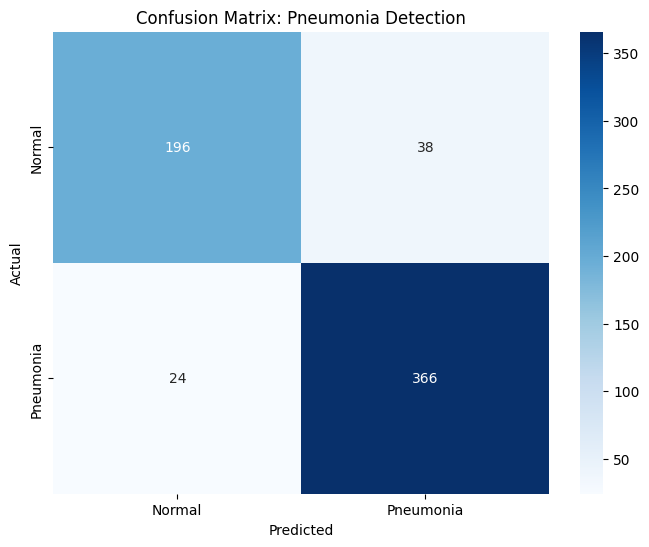

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Pneumonia Detection')
plt.show()

# More of data augmentation

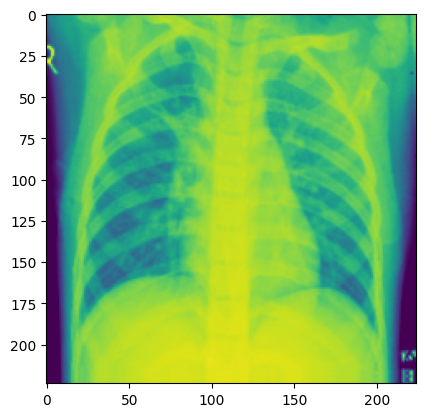

In [22]:
image = augmented_images[4]
plt.imshow(image.numpy().astype("uint8").squeeze())#, cmap='gray')

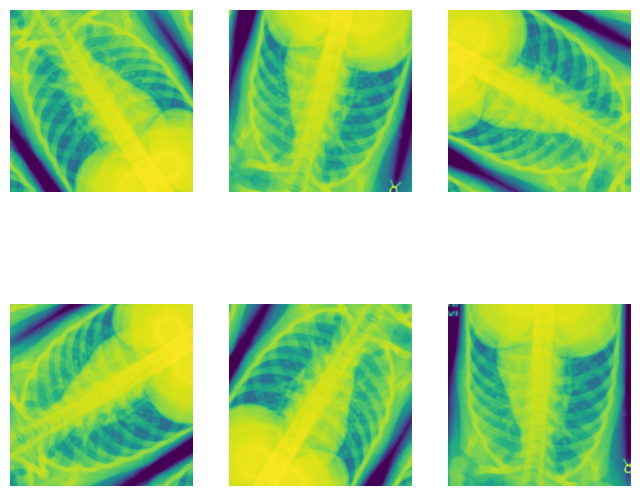

In [24]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")